<a href="https://colab.research.google.com/github/hungngo97/Sparse-Regression/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Import libraries in to read MNIST dataset and the trio python library to perform data analysis
It is convenient that the keras package in Tensorflow is already built in with MNIST dataset because it is extremely popular for people to test new algorithms in this classic dataset.



In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# x_train.shape = (60000, 28, 28)
# y_train.shape = (60000,)
# x_test.shape = (10000, 28, 28)
# y_test.shape = (10000, )

# Step 2: Perform data preprocessing
Since we need to perform a linear regression and find the relationship between images to its corresponding labels, aka solving the linear equation systems: Ax = B. We need to build our image matrix A and label B to solve for the coefficients.
In this problem, we want to have matrix A is an (784 x 60000) matrix such that each column is one image (28 x 28) and concat the images to a single column vector, then we stack 60000 of such vectors to build the matrix A.
The labels B are one hot encoded vectors indicate the label (digit representation) of that image. Because the labels from keras is a single scalar value (i.e: 2, 3 ,5 etc). We need to use sklearn preprocessing package that encode each value and put the labels as a one hot encoded vector that has a 1 in its corresponding entry and 0 everywhere else.


In [0]:
from sklearn.preprocessing import OneHotEncoder
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)
y_train = enc.transform(y_train)

y_train = np.transpose(y_train)
y_test = np.transpose(y_test)

x_train = np.transpose(x_train).reshape((28*28, 60000))
x_test = np.transpose(x_test).reshape((28*28, 10000))

**Example of training image and its label, change the index variable to see different image**

Digit in the image:  1


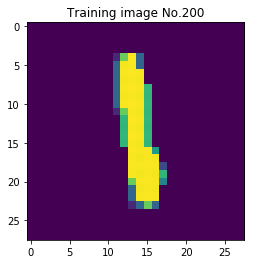

In [0]:
index = 200
label = y_train[:, index]
print ('Digit in the image: ', np.argmax(label))
plt.imshow(np.transpose(np.reshape(x_train[:,index], (28,28))))
plt.title("Training image No." + str(index))
plt.show()

def plot_image(instance, label):
  print ('Digit in the image: ', label)
  plt.imshow(np.transpose(np.reshape(instance, (28,28))))
  plt.title("Training image No." + str(index))
  plt.show()

# Step 3: Perform Various Regression Algorithms to Extract Important Features in Images

In [0]:
from sklearn import linear_model

#Lasso
A  = np.transpose(x_train)
b  = np.transpose(y_train)
clf_lasso = linear_model.Lasso(alpha=0.5)
clf_lasso.fit(A[()], b.toarray())

# Ridge 
# clf_ridge = linear_model.Ridge(alpha=0.8)
# clf_ridge.fit(A[()], b.toarray())



Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.8, l1_ratio=0.7)
enet.fit(A[()], b.toarray())

ElasticNet(alpha=0.8, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
#PseudoInverse
A_inv = np.linalg.pinv(A)
A_inv = np.array(A_inv)
b_arr = np.array(b)
coeff_inv = A_inv * b

In [0]:
import matplotlib.ticker as mtick

def plot_coeff(coef):
  feature_coef = np.array(coef)
  fig=plt.figure(figsize=(12, 6))
  fig.suptitle("Features in each digit", fontname="Times New Roman Bold")
  fig.subplots_adjust(wspace=None,hspace=None)
  columns = 5
  rows = 2
  for i in range(1, columns*rows + 1):
      img = feature_coef[i - 1,:]
      ax = fig.add_subplot(rows, columns, i)
      plt.imshow(np.transpose(np.reshape(img, (28,28))))
#       ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
      plt.title("Digit " + str(i - 1))
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
  plt.colorbar(orientation="horizontal", pad=0.05)
  plt.show()

def bar_plot_coeff(coef):
  feature_coef = np.array(coef)
  fig=plt.figure(figsize=(40, 25))
  fig.suptitle("Features Histogram in each digit", fontname="Times New Roman Bold")
  fig.subplots_adjust(wspace=None,hspace=None)
  columns = 5
  rows = 2
  x=range(784)
  for i in range(1, columns*rows + 1):
      img = feature_coef[i - 1,:]
      ax = fig.add_subplot(rows, columns, i)
      plt.bar(x, img)
      ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
      plt.title("Digit " + str(i - 1))
      plt.xlabel("Pixels")
      plt.ylabel("Coefficient Value")
  plt.show()  

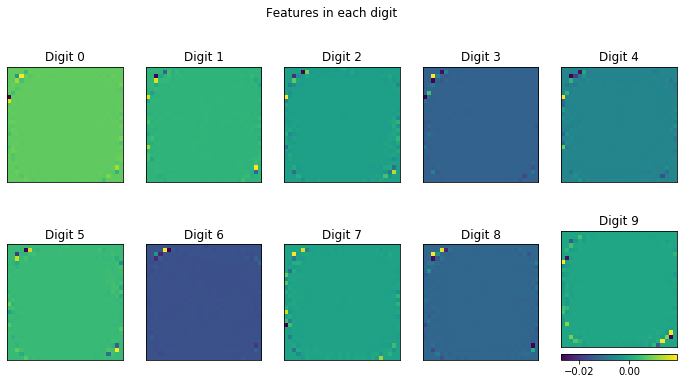

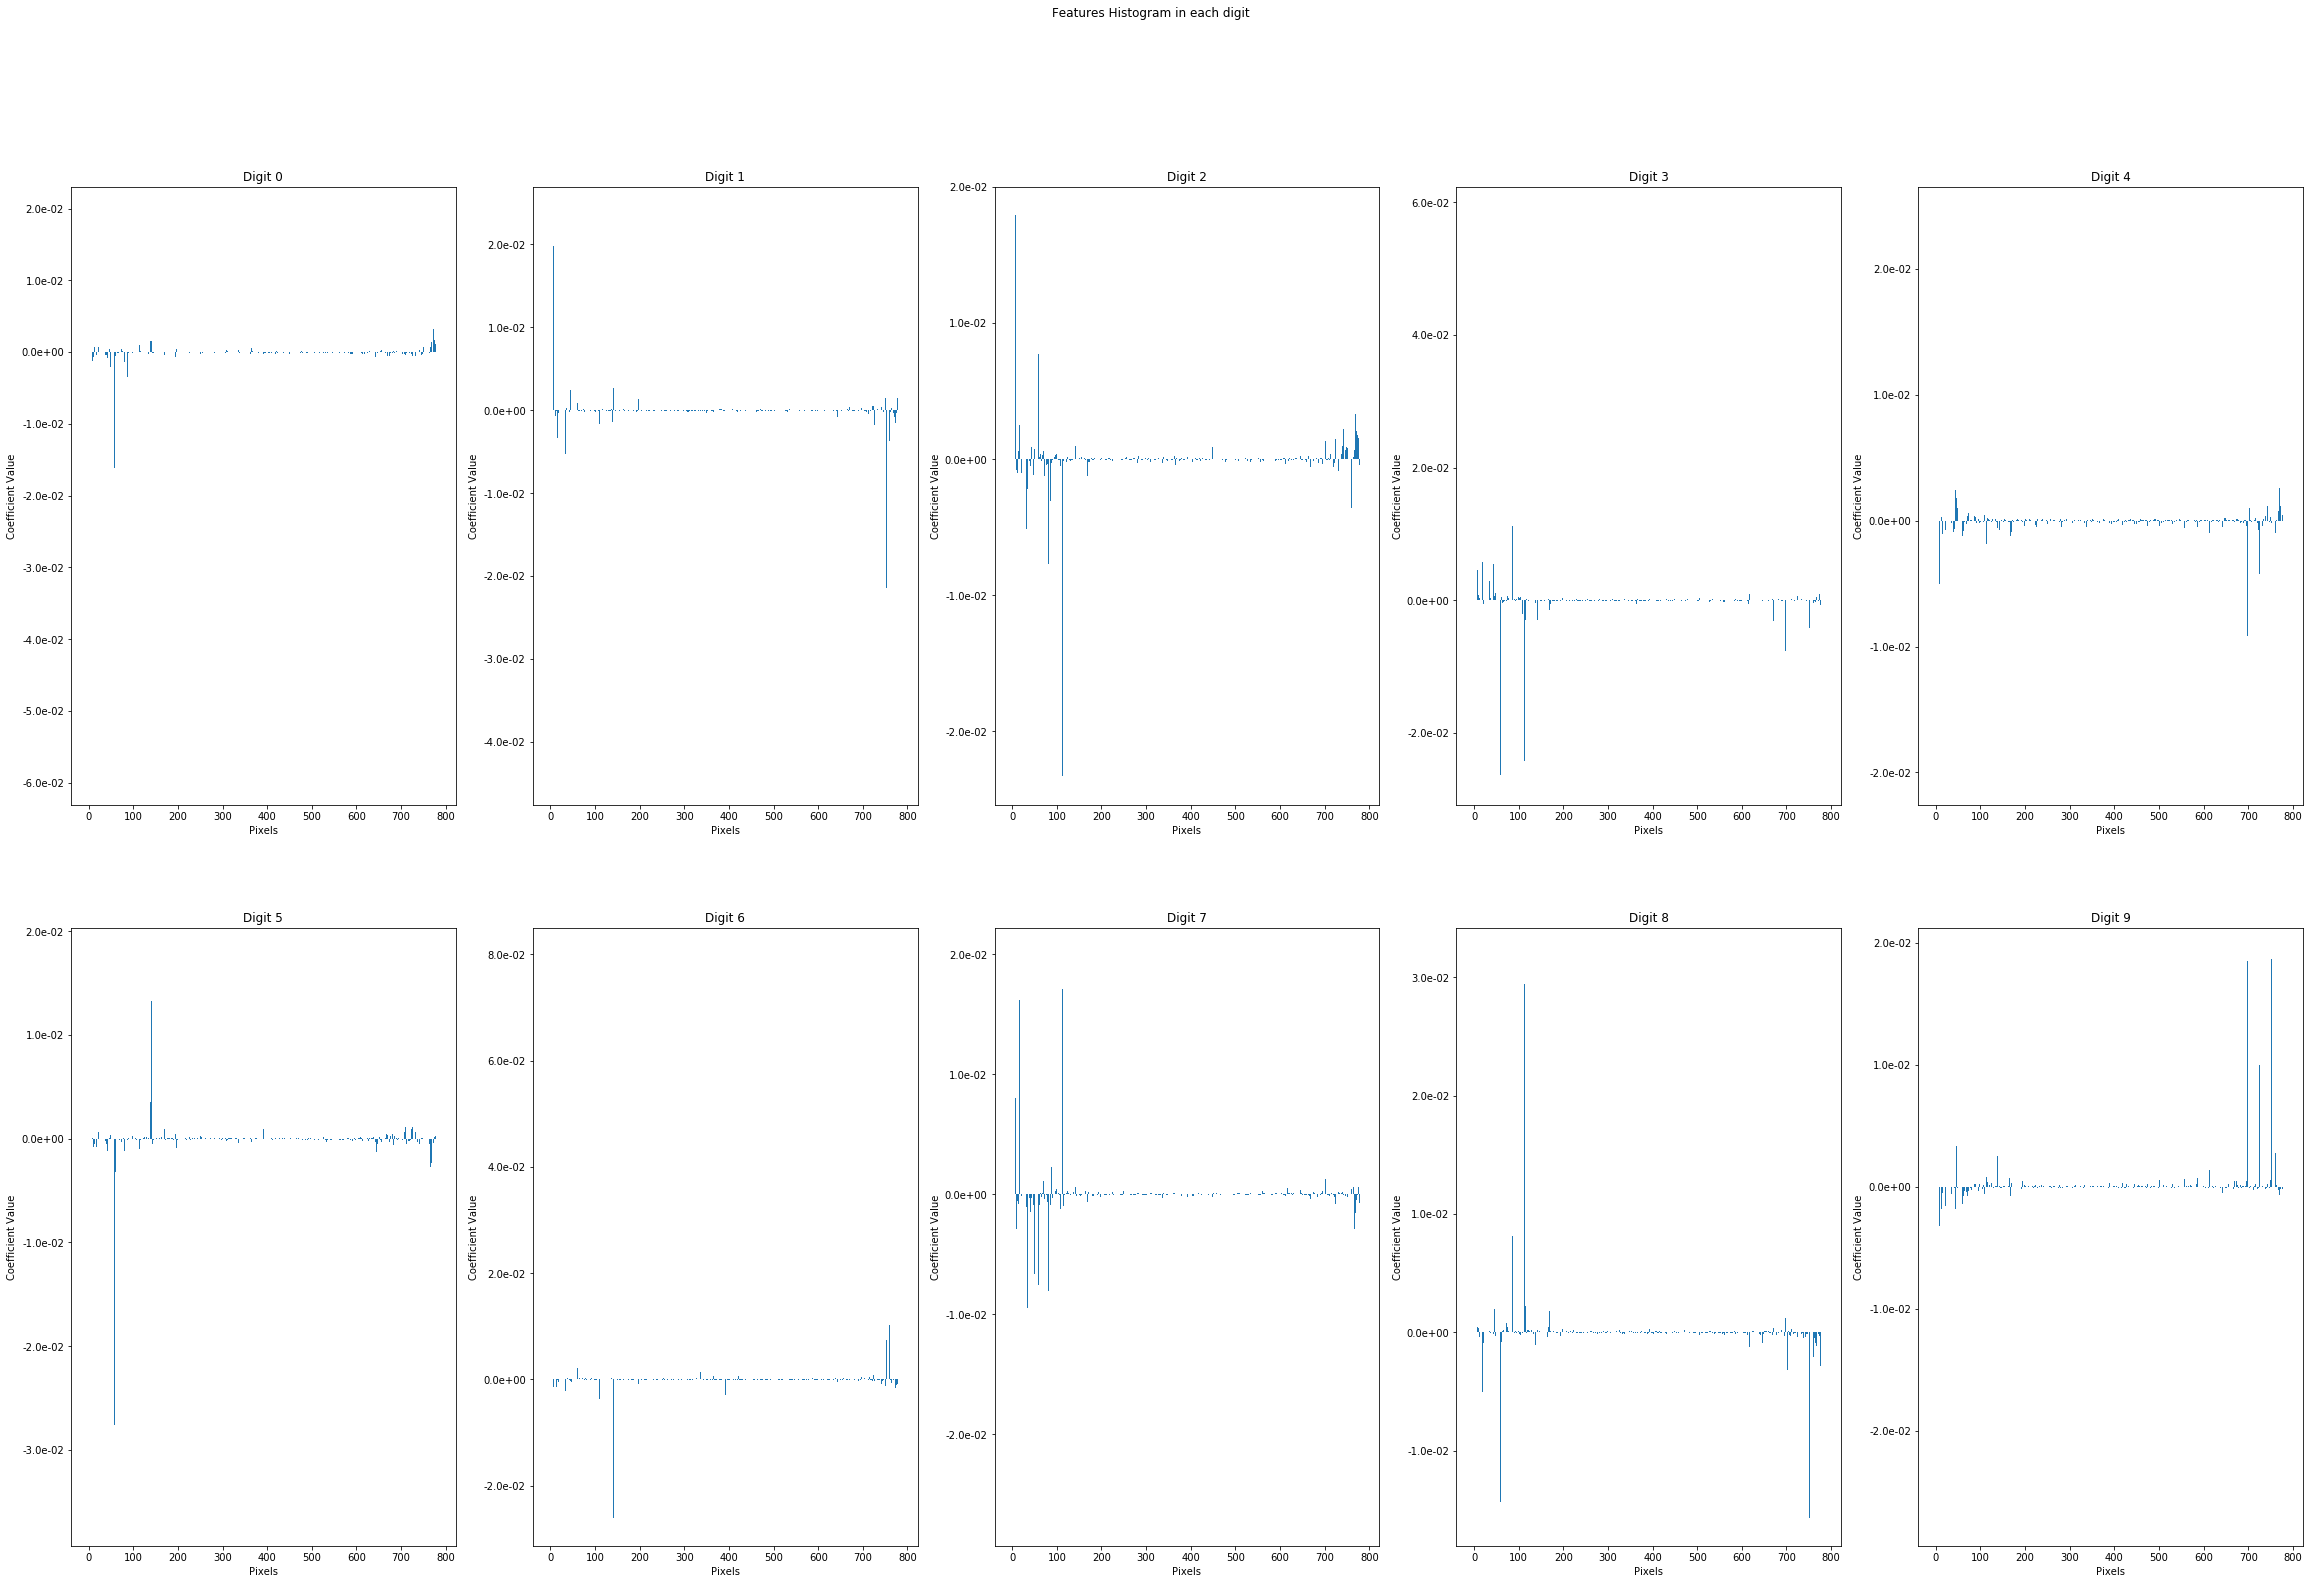

In [0]:
# plot_coeff(clf_lasso.coef_)
# bar_plot_coeff(clf_lasso.coef_)

# plot_coeff(enet.coef_)
# bar_plot_coeff(enet.coef_)

# plot_coeff(clf_ridge.coef_)
# bar_plot_coeff(clf_ridge.coef_)


# plot_coeff(np.transpose(coeff_inv))
# bar_plot_coeff(np.transpose(coeff_inv)) #Everyone is small

# Step 4: Verify on Test Set and Visualize the Important Features

In [0]:
y_predicted_lasso = clf_lasso.predict(np.transpose(x_test))
y_predicted_lasso_test = np.argmax(y_predicted_lasso, axis=1)

# y_predicted_lasso = enet.predict(np.transpose(x_test))
# y_predicted_lasso_test = np.argmax(y_predicted_lasso, axis=1)

# y_predicted_lasso = clf_ridge.predict(np.transpose(x_test))
# y_predicted_lasso_test = np.argmax(y_predicted_lasso, axis=1)

# y_predicted_lasso = np.matmul(np.transpose(x_test), coeff_inv)
# y_predicted_lasso_test = np.argmax(y_predicted_lasso, axis=1)

Digit in the image:  1


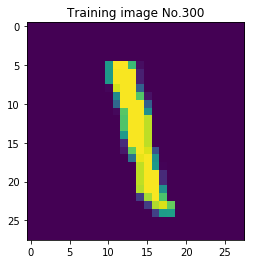

In [0]:
plot_image(x_test[:, 700], y_predicted_lasso_test[700])

In [0]:
y_predicted_lasso_test = np.reshape(np.array(y_predicted_lasso_test), (1, 10000))

In [0]:
from sklearn.metrics import accuracy_score
score = np.mean(y_predicted_lasso_test == y_test)
# score = accuracy_score(y_predicted_lasso_test, y_test)
print('Overall accuracy: ' + str(score))

#Lasso score: 0.8354 with alpha=0.8 => less features
#Lasso Score: 0.8473 with alpha = 0.5 => more features
#Lasso Score: 0.8575 with alpha = 0.1 => more feature and really close to plain regression
#Lasso Score: 0.8543 with alpha = 0.25 
#Lasso Score: 0.831 with alpha = 1

#Elastic Net: 0.8446
#Pseudo Inverse: 0.8534
#Ridge: 0.8603

Overall accuracy: 0.8473


Digit in the image:  1


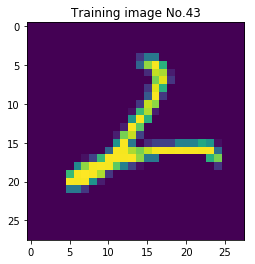

Actual Digit in the image:  2


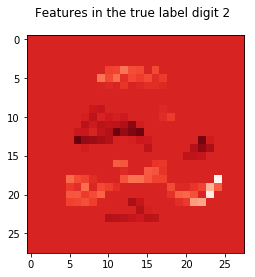

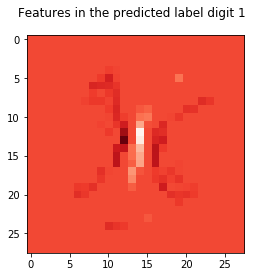

In [0]:
#Number 8
# index 80 the number 7


index = 50 #any particular index that we want to check out

# Find index of the particular number that we want to check the accuracy
number = 2
#which value = number that wanted to check out since there are many values equal
# that number
value = 3
index = np.argwhere(y_test==number)[value][1]

plot_image(x_test[:, index], y_predicted_lasso_test[0, index])
print ('Actual Digit in the image: ', y_test[0, index])



feature_coef = np.array(clf_lasso.coef_)
fig=plt.figure(figsize=(4, 4))
fig.suptitle("Features in the true label digit " + str(y_test[0, index]))
fig.subplots_adjust(wspace=None,hspace=None)
columns = 5
rows = 2
# Try matching with the feature space to see what feature did the regression 
# pick up for this current digit
img = feature_coef[y_test[0, index],:]
plt.imshow(np.transpose(np.reshape(img, (28,28))),cmap=plt.get_cmap('Reds_r'))

if y_predicted_lasso_test[0, index] != y_test[0, index]:
#   Then we can plot out the feature space for that incorrectly predicted image
#   to see why the algorithm mistakenly classify
  img = feature_coef[y_predicted_lasso_test[0, index],:]
  fig=plt.figure(figsize=(4, 4))
  fig.suptitle("Features in the predicted label digit " + str(y_predicted_lasso_test[0, index]))
  fig.subplots_adjust(wspace=None,hspace=None)
  columns = 5
  rows = 2
  plt.imshow(np.transpose(np.reshape(img, (28,28))),cmap=plt.get_cmap('Reds_r'))

In [0]:
#Try to suppress other coefficient of Lasso coefficients
# lasso_coeff = np.copy(enet.coef_)

lasso_coeff = np.copy(clf_lasso.coef_)
thresh = np.mean(lasso_coeff)
# threshold_indices = lasso_coeff < thresh
# threshold_indices = lasso_coeff < thresh /2 
# threshold_indices = lasso_coeff < 2 * thresh
threshold_indices = lasso_coeff < 8 * thresh
# threshold_indices = lasso_coeff < thresh / 4 
lasso_coeff[threshold_indices] = 0
#the coefficients that are not important will be set to 0

In [0]:
y_predicted_lasso = np.matmul(np.transpose(x_test),np.transpose(lasso_coeff))
y_predicted_lasso_test = np.argmax(y_predicted_lasso, axis=1)
y_predicted_lasso_test = np.reshape(np.array(y_predicted_lasso_test), (1, 10000))
from sklearn.metrics import accuracy_score
score = np.mean(y_predicted_lasso_test == y_test)
# score = accuracy_score(y_predicted_lasso_test, y_test)
print('Overall accuracy: ' + str(score))

Overall accuracy: 0.7004


In [0]:
print("Original nonzero coefficients: " + str(np.count_nonzero(clf_lasso.coef_)))
print("Threshold nonzero coefficients: " + str(np.count_nonzero(lasso_coeff)))

Original nonzero coefficients: 552
Threshold nonzero coefficients: 321


In [0]:
# When threshold = mean of lasso coef (< thresh)
# Overall accuracy: 0.8473 with full coefficients
# Overall accuracy: 0.7346
# Original nonzero coefficients: 552
# Threshold nonzero coefficients: 527

# When threshold = mean of lasso coef /2  (< thresh / 2)
# Overall accuracy: 0.8473 with full coefficients
# Overall accuracy: 0.7344
# Original nonzero coefficients: 552
# Threshold nonzero coefficients: 542

# When threshold = mean of lasso coef * 2 (< thresh* 2)
# Overall accuracy: 0.8473 with full coefficients
# Overall accuracy: 0.732
# Original nonzero coefficients: 1137
# Threshold nonzero coefficients: 496

# When threshold = mean of lasso coef * 8 (< thresh* 8)
# Overall accuracy: 0.8473 with full coefficients
# Overall accuracy: 0.7044
# Original nonzero coefficients: 1137
# Threshold nonzero coefficients: 321


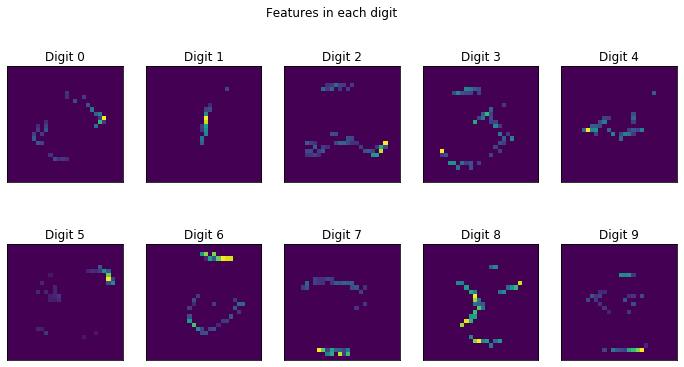

In [0]:
plot_coeff(lasso_coeff)